In [1]:
import torch
from torch.autograd import Variable

import numpy as np

from tqdm import tqdm

from torch.utils.data import DataLoader

from flair.data import Sentence
from flair.embeddings import WordEmbeddings

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

from gensim.models import KeyedVectors

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dataset import BibleDataset, custom_collate_fn
from abae import AspectAutoencoder
from loss import TripletMarginCosineLoss, OrthogonalityLoss

In [2]:
dataset = BibleDataset("./t_bbe.csv", word_to_index=True)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=custom_collate_fn)

2021-06-12 21:36:05,705 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:06,492 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:06,760 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,197 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,200 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,201 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,201 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,203 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,215 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-06-12 21:36:08,215 Warning: An empty Sentence was 

In [3]:
""" Generate Word Vectors for a Given Dataset """

glove_embedding = WordEmbeddings('glove')

embed_size = glove_embedding.embedding_length
vocab_size = dataset.vocab_size
wv = KeyedVectors(vector_size=embed_size)

embeddings = torch.empty(vocab_size, embed_size)

for word, id in tqdm(dataset.word2id.items(), position=0, leave=True):
    word = Sentence(word)
    glove_embedding.embed(word)
    for token in word:
        embeddings[id] = token.embedding

wv.add(list(dataset.word2id.keys()), embeddings.cpu().numpy())

100%|██████████| 5914/5914 [00:07<00:00, 839.66it/s] 


In [12]:
""" Find K aspects in a Given Dataset using K-Means """

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(wv.vectors)
centers = kmeans.cluster_centers_

for i in range(n_clusters):
    print([word for word, _ in wv.similar_by_vector(centers[i])])
    print()

['love', 'sense', 'mind', 'spirit', 'true', 'passion', 'life', 'thoughts', 'kind', 'feelings']

['cleopas', 'arioch', 'kamon', 'adalia', 'eglon', 'crescens', 'machir', 'agur', 'kohath', 'baasha']

['fifteen', 'twenty', 'thirty', 'forty', 'fourteen', 'fifty', 'sixteen', 'thirteen', 'twelve', 'eleven']

['company', 'smyrna', 'builder', 'medan', 'boatmen', 'keystone', 'creditor', 'debtor', 'cos', 'valuing']

['room', 'rooms', 'floor', 'floors', 'walls', 'window', 'roof', 'houses', 'doors', 'inside']

['james', 'david', 'thomas', 'john', 'peter', 'michael', 'daniel', 'matthew', 'stephen', 'andrew']

['even', 'something', 'nothing', 'know', 'going', 'come', 'everyone', 'get', 'things', 'way']

['syria', 'egypt', 'lebanon', 'arab', 'israel', 'egyptian', 'gaza', 'syrian', 'damascus', 'rulers']

['legs', 'chest', 'nose', 'neck', 'fingers', 'skin', 'stomach', 'throat', 'eyes', 'ear']

['time', 'last', 'first', 'came', 'one', 'second', 'three', 'two', 'day', 'coming']

['higher', 'price', 'marke

In [13]:
def coverage(data, dist="cosine"):
    if dist == "cosine":
        mins = (cosine_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    elif dist == "euclidean":
        mins = (euclidean_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    return np.square(np.var(mins)) / mins.mean()

In [14]:
w_emb = torch.from_numpy(wv.vectors)
a_emb = torch.from_numpy(centers)
seed_w = None
num_seeds = None
lr = 0.01
epochs = 50
min_len = 1
l = 0.1
fix_a_emb = False

net = AspectAutoencoder(vocab_size, embed_size, num_aspects=n_clusters, neg_samples=10, w_emb=w_emb, a_emb=a_emb, recon_method="centr", seed_w=seed_w, num_seeds=num_seeds, attention=True, fix_w_emb=True, fix_a_emb=fix_a_emb)

if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    net = net.cuda()

rec_loss = TripletMarginCosineLoss()
orth_loss = OrthogonalityLoss()

params = filter(lambda p: p.requires_grad, net.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [15]:
net.train()
for epoch in range(epochs):

    for lines, ids in tqdm(dataloader, position=0, leave=True):
        inputs = Variable(torch.Tensor(lines).long())

        if inputs.shape[1] < min_len:
            continue

        if torch.cuda.is_available():
            inputs = inputs.cuda()

        out, a_probs = net(inputs)

        positives, negatives = net.get_targets()
        loss = rec_loss(out, positives, negatives)

        if not fix_a_emb:
            aspects = net.get_aspects()
            loss += l * orth_loss(aspects)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 622/622 [00:03<00:00, 186.41it/s]


In [16]:
abae_centers = net.get_aspects().detach().cpu().numpy()

for i in range(n_clusters):
    print([word for word, _ in wv.similar_by_vector(abae_centers[i])])
    print()

['sorrow', 'joy', 'passion', 'spirit', 'grief', 'pride', 'glory', 'uplifting', 'delight', 'feelings']

['pharaoh', 'abimelech', 'rameses', 'ahasuerus', 'birthright', 'nebuchadnezzar', 'jewels', 'herod', 'stamps', 'melchizedek']

['fourteen', 'sixty', 'eighty', 'seventeen', 'nineteen', 'sixteen', 'eighteen', 'fifteen', 'seventy', 'thirteen']

['zur', 'acco', 'tob', 'gunite', 'gether', 'sin', 'hesed', '!', 'waste', 'sirs']

['lord', 'garden', 'church', 'gardens', 'altar', 'rooms', 'churches', 'houses', 'worship', 'temple']

['meshullam', 'asher', 'alvan', 'machir', 'paltiel', 'neriah', 'jehoram', 'hanoch', 'jehiel', 'alphaeus']

['everybody', 'thing', 'know', 'look', 'happier', 'looks', 'going', 'things', 'wondering', 'cares']

['rulers', 'syria', 'hilltops', 'neighbours', 'jews', 'lebanon', 'jerusalem', 'persia', 'israel', 'neighbouring']

['stomach', 'chest', 'ear', 'cord', 'neck', 'throat', 'liver', 'mouth', 'bone', 'wound']

['straight', 'fourth', 'sixth', 'seventh', 'eighth', 'fifth

In [17]:
coverage(centers), coverage(abae_centers)

(0.0012551458268828454, 3.613356302848305e-10)

In [18]:
outs = list()
poss = list()
aspects = list()
recon_embedding = list()
orign_embedding = list()
for lines, ids in dataloader:
    inputs = Variable(torch.Tensor(lines).long())

    if inputs.shape[1] < min_len:
        continue

    if torch.cuda.is_available():
        inputs = inputs.cuda()

    out, a_probs = net(inputs)

    positives, negatives = net.get_targets()

    outs.append(out.detach().cpu().numpy())
    poss.append(positives.detach().cpu().numpy())
    aspects.append(a_probs.detach().cpu().numpy())

    recon_embedding.append(out.detach().cpu().numpy())
    orign_embedding.append(positives.detach().cpu().numpy())

outs = np.concatenate(outs, axis=0)
poss = np.concatenate(poss, axis=0)
aspects = np.concatenate(aspects, axis=0)

cos_dis = list()
for a, b in zip(outs, poss):
    cos_dis.append(cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0, 0])
print(sum(cos_dis), sum(cos_dis) / len(cos_dis))

cos_dis_stat = [np.sum(np.array(cos_dis) <= i * 0.1) for i in range(1, 11)]
print(cos_dis_stat)

aspects_embedding = aspects.copy()
aspects = np.argmax(aspects, axis=1)
aspects_stat = [np.sum(aspects == i) for i in range(n_clusters)]
print(aspects_stat)

recon_embedding = np.concatenate(recon_embedding, axis=0)
orign_embedding = np.concatenate(orign_embedding, axis=0)
print(f"Epoch {epoch+1}", "recon: ", coverage(recon_embedding, "cosine"), "orign: ", coverage(orign_embedding, "cosine"))

15140.088637113571 0.4870858230258846
[0, 0, 109, 5055, 19324, 27571, 30153, 30816, 30967, 31070]
[4095, 229, 2151, 385, 3631, 2333, 1218, 736, 458, 698, 275, 371, 1750, 240, 3232, 565, 343, 251, 474, 524, 416, 282, 428, 614, 619, 149, 1127, 2218, 519, 752]


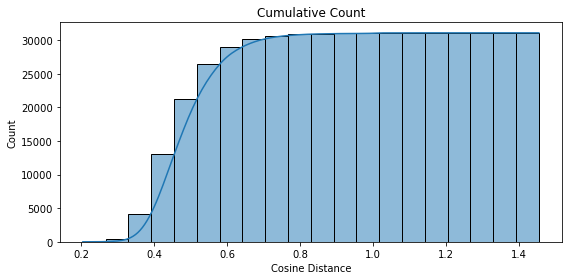

In [19]:
plt.figure(figsize=(8,4), tight_layout=True)
ax = sns.histplot(cos_dis, cumulative=True, bins=20, kde=True)
ax.set(title="Cumulative Count", xlabel="Cosine Distance", ylabel="Count")
plt.show()